In [64]:
from glob import glob
import os
import matplotlib.pyplot as plt

import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
from torch.utils.data import Dataset

def first_data_key(matdict: dict) -> str:
    for k in matdict.keys():
        if not k.startswith("__"):
            return k
    raise KeyError("No data key found in .mat file")

def cplx_to_2ch(x: torch.Tensor) -> torch.Tensor:
    return torch.stack([x.real, x.imag], dim=1)

class SPENDataset(Dataset):
    """
    For each <id>.mat it loads:
      gt    : <root>/data/<id>.mat
      y_file: <root>/final_rxyacq_ROFFT/<id>.mat
      phase : <root>/phase_map/<id>.mat
    """

    def __init__(self, root: str, lr_dir: str = "final_rxyacq_ROFFT", phase_dir: str = "phase_map"):
        self.root = root
        self.lr_dir = lr_dir
        self.phase_map_dir = phase_dir

        self.data_files = sorted(glob(os.path.join(root, "data", "*.mat")))
        if len(self.data_files) == 0:
            raise FileNotFoundError(f"No .mat files in {os.path.join(root, 'data')}")

    def __len__(self):
        return len(self.data_files)

    def _load_mat(self, path: str) -> np.ndarray:
        d = sio.loadmat(path)
        arr = d[first_data_key(d)]
        return np.squeeze(np.asarray(arr))

    def _np_to_torch_complex(self, arr: np.ndarray) -> torch.Tensor:
        if np.iscomplexobj(arr):
            return torch.from_numpy(arr).to(torch.complex64)
        return torch.from_numpy(arr.astype(np.float32)).to(torch.complex64)

    def __getitem__(self, idx):
        data_path = self.data_files[idx]
        stem = os.path.splitext(os.path.basename(data_path))[0]
        
        gt_np = self._load_mat(data_path)
        gt = self._np_to_torch_complex(gt_np)

        ph_path = os.path.join(self.root, self.phase_map_dir, stem + ".mat")
        if not os.path.exists(ph_path):
            raise FileNotFoundError(f"Missing phase map file: {ph_path}")
        ph_np = self._load_mat(ph_path)
        phase_map = self._np_to_torch_complex(ph_np)

        lr_path = os.path.join(self.root, self.lr_dir, stem + ".mat")
        if not os.path.exists(lr_path):
            raise FileNotFoundError(f"Missing LR file: {lr_path}")
        lr_np = self._load_mat(lr_path)
        lr = self._np_to_torch_complex(lr_np)

        return {"id": stem, "gt": gt, "lr": lr, "phase_map": phase_map}

class ResidualBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(ch, ch, 3, bias=False),
            nn.InstanceNorm2d(ch, affine=True),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(ch, ch, 3, bias=False),
            nn.InstanceNorm2d(ch, affine=True),
        )
    def forward(self, x):
        return x + self.block(x)

class ResNetRefiner(nn.Module):
    def __init__(self, in_ch=2, out_ch=2, n_blocks=6, base=64):
        super().__init__()
        layers = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_ch, base, 7, bias=False),
            nn.InstanceNorm2d(base, affine=True),
            nn.ReLU(inplace=True),
        ]
        ch = base
        # Down
        for _ in range(2):
            layers += [
                nn.Conv2d(ch, ch * 2, 3, stride=2, padding=1, bias=False),
                nn.InstanceNorm2d(ch * 2, affine=True),
                nn.ReLU(inplace=True),
            ]
            ch *= 2
        # Residuals
        for _ in range(n_blocks):
            layers += [ResidualBlock(ch)]
        # Up
        for _ in range(2):
            layers += [
                nn.ConvTranspose2d(ch, ch // 2, 3, stride=2, padding=1, output_padding=1, bias=False),
                nn.InstanceNorm2d(ch // 2, affine=True),
                nn.ReLU(inplace=True),
            ]
            ch //= 2
        layers += [nn.ReflectionPad2d(3), nn.Conv2d(ch, out_ch, 7)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class PatchDiscriminator(nn.Module):
    def __init__(self, in_ch=2):
        super().__init__()
        def C(i, o, ks=4, s=2, p=1, norm=True):
            L = [nn.Conv2d(i, o, ks, s, p)]
            if norm:
                L += [nn.InstanceNorm2d(o)]
            L += [nn.LeakyReLU(0.2, inplace=True)]
            return L
        L = []
        L += C(in_ch, 64, norm=False)
        L += C(64, 128)
        L += C(128, 256)
        L += [nn.Conv2d(256, 512, 4, stride=1, padding=1),
              nn.InstanceNorm2d(512),
              nn.LeakyReLU(0.2, inplace=True)]
        L += [nn.Conv2d(512, 1, 4, stride=1, padding=1)]
        self.net = nn.Sequential(*L)
    def forward(self, x):
        return self.net(x)

In [65]:
dt = SPENDataset("/home/data1/musong/workspace/2025/8/08-20/tr/data/IXI_sim")

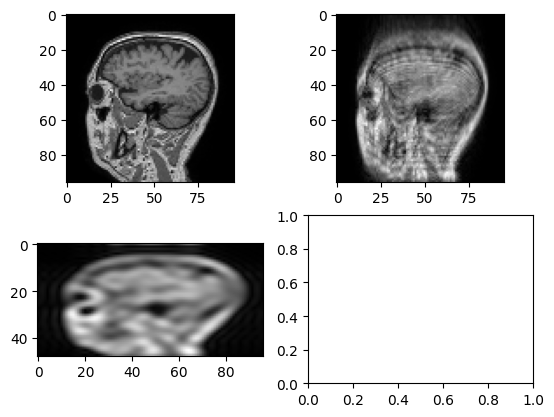

In [66]:
fig, axs =plt.subplots(2, 2)
axs[0, 0].imshow(np.abs(dt[0]["gt"].numpy()), cmap="gray")
axs[0, 1].imshow(np.abs(dt[0]["lr"].numpy()), cmap="gray")
axs[1, 0].imshow(dt[0]["phase_map"].real.numpy(), cmap="gray")

In [67]:
G1 = ResNetRefiner(in_ch=2, out_ch=2, n_blocks=2, base=64)
G2 = ResNetRefiner(in_ch=2, out_ch=2, n_blocks=2, base=64)
D  = PatchDiscriminator(in_ch=2)

# calculate the parameters of G1 and D
print(f"G1: {sum(p.numel() for p in G1.parameters() if p.requires_grad)}")
print(f"D: {sum(p.numel() for p in D.parameters() if p.requires_grad)}")

G1: 3112450
D: 2763713


In [68]:
phase_map = dt[0]['phase_map'].unsqueeze(0)
lr = dt[0]['lr'].unsqueeze(0)

In [69]:
pred_pm = G1(cplx_to_2ch(phase_map))
pred_hr = G2(cplx_to_2ch(lr))

In [70]:
cplx_to_2ch(lr).shape

torch.Size([1, 2, 96, 96])